In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from scipy.stats import skew, kurtosis
from statsmodels.stats.anova import anova_lm
from scipy.stats import zscore

In [2]:
csv_path = "../data/cleaned_pet_proactive_mock_data.csv"
df = pd.read_csv(csv_path)

print(df.shape)

print("First 5 rows:")
df.head()

(1017, 16)
First 5 rows:


,pet_id,species,age,weight_kg,condition,treatment,visit_date,cost_gbp,year,month,age_group,insured,insurance_plan,coverage_rate,covered_gbp,out_of_pocket_gbp
0,P0001,Dog,6.000000,10.6,Arthritis,Dental cleaning,2023-04-08,277.310000,2023,4,6-10,True,Lifetime,0.830259,230.24,47.07
1,P0002,Cat,9.486667,2.1,Unknown,Surgery,2023-11-24,164.880000,2023,11,6-10,False,NaN,0.000000,0.00,164.88
2,P0003,Dog,9.486667,27.6,Gastroenteritis,Diet consultation,2023-01-01,218.244766,2023,1,6-10,True,Lifetime,0.893684,195.04,23.20
3,P0004,Dog,1.000000,16.9,Allergy,Vaccination,2023-09-20,218.244766,2023,9,0-2,True,Accident-only,0.532569,116.23,102.01
4,P0004,Dog,1.000000,16.9,Allergy,Vaccination,2023-03-21,224.709281,2023,9,0-2,True,Accident-only,0.637794,143.32,81.39


## 1. CORE DESCRIPTIVE ANALYSIS (FND)

* Cost distributions (skewness, fat tails, etc.).

* Variance decomposition --> how much of cost variation comes from species vs condition vs treatment (ANOVA)

* Correlation between cost and insurance. (what ?)

* Outlier analysis


---

**a) Cost distributions**

* Plotting histogram + KDE of `cost_gbp`.
* Checking skewness and kurtosis.
* Understand whether distribution is heavy-tailed (a few extreme cases dominating).
* Use log-transformed cost if right-skewed (common in medical/vet data) (stretch goal)


In [3]:
print(df.describe())

               age    weight_kg     cost_gbp    year        month  \
count  1017.000000  1017.000000  1017.000000  1017.0  1017.000000   
mean      9.307847     9.889311   208.179833  2023.0     6.706981   
std       5.342660     7.275665   129.384393     0.0     3.385745   
min       0.000000     0.500000     0.140000  2023.0     1.000000   
25%       5.000000     4.300000   106.170000  2023.0     4.000000   
50%       9.486667     8.757220   209.668084  2023.0     7.000000   
75%      13.000000    13.800000   293.178439  2023.0    10.000000   
max      19.000000    34.900000   672.906176  2023.0    12.000000   

       coverage_rate  covered_gbp  out_of_pocket_gbp  
count    1017.000000  1017.000000        1017.000000  
mean        0.238405    48.317925         159.861681  
std         0.348567    87.389286         132.926079  
min         0.000000     0.000000           0.140000  
25%         0.000000     0.000000          45.700000  
50%         0.000000     0.000000         124.17

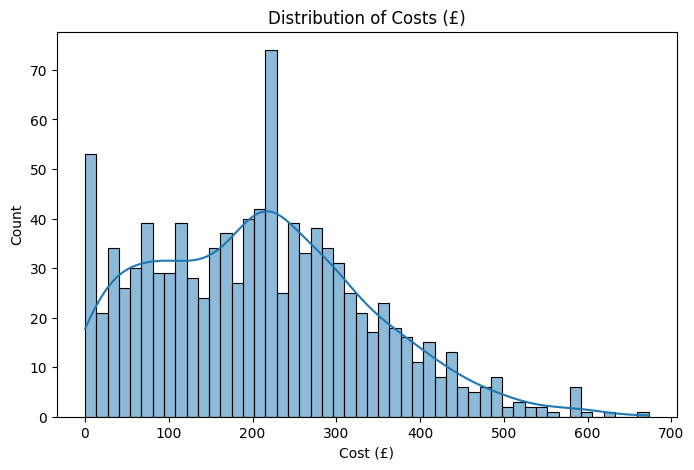

Skewness: 0.45, Kurtosis: -0.17


In [4]:
# Histogram + KDE
plt.figure(figsize=(8,5))
sns.histplot(df["cost_gbp"], bins=50, kde=True)
plt.title("Distribution of Costs (£)")
plt.xlabel("Cost (£)")
plt.show()

# Skewness & Kurtosis
skew = stats.skew(df["cost_gbp"], nan_policy="omit")
kurt = stats.kurtosis(df["cost_gbp"], nan_policy="omit")
print(f"Skewness: {skew:.2f}, Kurtosis: {kurt:.2f}")

# Optional: log-transform
df["log_cost"] = np.log1p(df["cost_gbp"])  # log(1+x) to avoid log(0)


**Most costs cluster around £200, with a tail reaching up to about £700. <br>**
**The peak sits near £200–£210.<br>**
**The distribution shows a right skew and is slightly flatter than normal (platykurtic).**

---
Key numbers to display
-  Mode: £200–£210
-  Min: £0
-  Max: £700
-  Mean: £208
-  Median: £209
-  Std dev: £129
-  25th percentile: £106
-  75th percentile: £293
-  Skewness: 0,45 (positive)
-  Kurtosis: -0,17 (platykurtic)

Implications
-  Not strongly non-normal; considering log-cost or nonparametric methods


In [6]:
# Focus on cost_gbp for cost analysis
cost = df["cost_gbp"].astype(float).dropna()
N = int(cost.shape[0])
mean_cost = float(cost.mean())
median_cost = float(cost.median())
sd_cost = float(cost.std(ddof=1))
q1 = float(cost.quantile(0.25))
q3 = float(cost.quantile(0.75))
iqr = q3 - q1
min_cost = float(cost.min())
max_cost = float(cost.max())
p5 = float(cost.quantile(0.05))
p95 = float(cost.quantile(0.95))
cv = sd_cost / mean_cost if mean_cost != 0 else np.nan
zeros = int((cost == 0).sum())

# Outliers (IQR method)
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = cost[(cost < lower_bound) | (cost > upper_bound)]
outlier_count = int(outliers.shape[0])

# Shape
skewness = float(skew(cost, bias=False))
kurt = float(kurtosis(cost, bias=False))

# Logs (for normalization checks)
log_cost = np.log1p(cost)
log_mean = float(log_cost.mean())
log_median = float(log_cost.median())
log_sd = float(log_cost.std(ddof=1))

log_cost_plus1 = np.log1p(cost + 1)
log1p_mean = float(log_cost_plus1.mean())
log1p_median = float(log_cost_plus1.median())
log1p_sd = float(log_cost_plus1.std(ddof=1))

# Tail summary
tail_95th = p95


results = {
    "n": N,
    "mean_gbp": mean_cost,
    "median_gbp": median_cost,
    "sd_gbp": sd_cost,
    "iqr_gbp": iqr,
    "min_gbp": min_cost,
    "max_gbp": max_cost,
    "p5_gbp": p5,
    "p95_gbp": p95,
    "cv": cv,
    "outlier_count": outlier_count,
    "outlier_values": list(outliers.values)[:5],  # sample preview
    "skewness": skewness,
    "kurtosis": kurt,
    "zero_costs": zeros,
    "log_cost_mean": log_mean,
    "log_cost_median": log_median,
    "log_cost_sd": log_sd,
    "log1p_cost_mean": log1p_mean,
    "log1p_cost_median": log1p_median,
    "log1p_cost_sd": log1p_sd,
    "tail_95th": tail_95th
}

# Pretty print as text summary
text_summary = f"""
Cost data (cost_gbp):
>  N = {N}, mean = {mean_cost:.2f}, median = {median_cost:.2f}, SD = {sd_cost:.2f}
>  min = {min_cost:.2f}, max = {max_cost:.2f}
>  5th pct = {p5:.2f}, 95th pct = {p95:.2f}
>  IQR = {iqr:.2f}, CV = {cv:.3f}
>  Zeros = {zeros}, Outliers (IQR rule) = {outlier_count}

Shape:
>  Skewness = {skewness:.3f}, Kurtosis = {kurt:.3f}
>  Interpretation: right-skewed with a noticeable tail; not extremely skewed.

Transformations:
>  log(Cost) stats -> mean {log_mean:.3f}, median {log_median:.3f}, SD {log_sd:.3f}
>  log(Cost+1) stats -> mean {log1p_mean:.3f}, median {log1p_median:.3f}, SD {log1p_sd:.3f}

Tail:
>  95th percentile = {p95:.2f}

"""

print(text_summary)

# Save JSON for downstream use if desired
import json
with open("cost_analysis_results.json", "w") as f:
    json.dump(results, f, indent=2)


TypeError: 'numpy.float64' object is not callable

**Analysis:**


Core Metrics
   *	N = 1 017
   *	Center: Mean £208,18; Median £209,67 (median ≈ mean)
   *	Spread: SD £129,38; IQR £187,01; CV 0,62
   *	Range: £0,14 to £672,91
   *	Percentiles: 5th £12,03; 95th £434,49
   *	Outliers: 9 (per IQR rule)


Shape and tails
   *	Skewness 0,446; Kurtosis -0,165
   *	Interpretation: mild to moderate right skew; unimodal with a not-too-sharp peak


Transformations (modeling-friendly)
   *	log(Cost): mean £5,006; median £5,350; SD £1,052
   *	log(Cost+1): mean £5,022; median £5,355; SD £1,016
   *	Takeaway: log views are more symmetric; good for modeling


Tail focus
   *	95th percentile £434,49
   *	Tail is notable but not extreme relative to max (£672,91)


Non-normality suggests using robust summaries (median, IQR) or transform-based/GLM approaches.

#TODO later Quick Model Comparison: Gamma vs Lognormal for Cost Distribution (AIC/BIC)

#### Quick visuals for better understanding cost-

In [7]:
df = df[df["cost_gbp"] > 0]
df["log_cost"] = np.log1p(df["cost_gbp"])

print("Rows:", df.shape[0])
print("Cost range: £{:.2f} – £{:.2f}".format(df["cost_gbp"].min(), df["cost_gbp"].max()))

Rows: 1017
Cost range: £0.14 – £672.91


<Figure size 600x400 with 0 Axes>

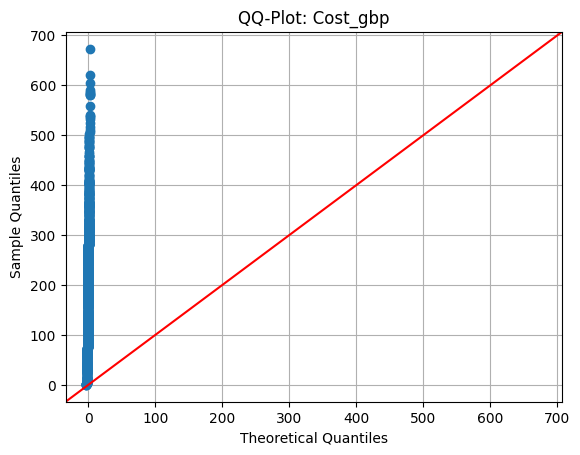

In [10]:
plt.figure(figsize=(6,4))
sm.qqplot(df["cost_gbp"], line='45')
plt.title("QQ-Plot: Cost_gbp")
plt.grid(True)
plt.show()


In [11]:
log_cost = df["log_cost"]
mean_log = float(log_cost.mean())
median_log = float(log_cost.median())
sd_log = float(log_cost.std(ddof=1))
skew_log = float(stats.skew(log_cost, bias=False))
kurt_log = float(stats.kurtosis(log_cost, bias=False))

print("log_cost: mean", mean_log, "median", median_log, "sd", sd_log, "skew", skew_log, "kurtosis", kurt_log)

# Optional: back-transform quick view (geometric-like center)
geom_center = np.exp(mean_log) - 1
print("Back-transformed (approx median on original scale):", round(geom_center, 2))


log_cost: mean 5.005524416014186 median 5.350283833754823 sd 1.0518728353540898 skew -1.7861756581937818 kurtosis 3.4686776439688547
Back-transformed (approx median on original scale): 148.24


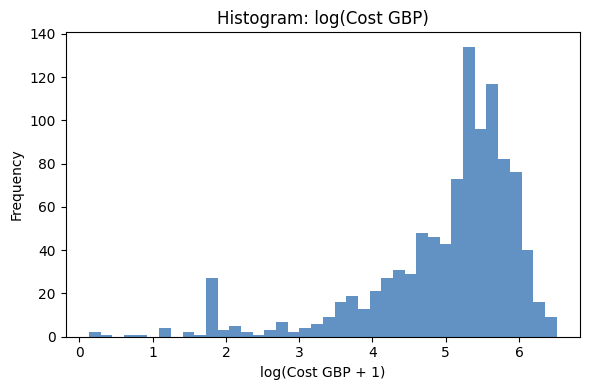

log_cost: mean 5.005524416014186 median 5.350283833754823 sd 1.0518728353540898 skew -1.7861756581937818 kurtosis 3.4686776439688547
Back-transformed median (GBP): £209.67


In [13]:
df = df[df['cost_gbp'] > 0]
df['log_cost'] = np.log1p(df['cost_gbp'])

# 1) Histogram of log_cost
plt.figure(figsize=(6,4))
plt.hist(df['log_cost'], bins=40, color="#2c6eaf", alpha=0.75)
plt.title("Histogram: log(Cost GBP)")
plt.xlabel("log(Cost GBP + 1)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 2) Quick stats for log_cost
mean_log = float(df['log_cost'].mean())
median_log = float(df['log_cost'].median())
sd_log = float(df['log_cost'].std(ddof=1))
skew_log = float(stats.skew(df['log_cost'], bias=False))
kurt_log = float(stats.kurtosis(df['log_cost'], bias=False))
print("log_cost: mean", mean_log, "median", median_log, "sd", sd_log, "skew", skew_log, "kurtosis", kurt_log)

# 3) Back-transform the central tendency (median) to GBP for reporting
back_median = np.expm1(median_log)
print("Back-transformed median (GBP): £{:.2f}".format(back_median))


Observations:
   *	Raw cost_gbp: strong right-skew; most costs around £100–£250, tail up to £600–£700.
   *	log_cost: left-skew on the log scale, with a cluster of high log values and a longer tail at the low end.


Central tendency:
   *	Back-transformed median ≈ £210 (about £209.67).


Why the log looks left-skewed:
   *	Log compression pulls down large values; if many costs map to similar high log-values, a few small costs create a left tail on the log scale.


Implications:
   *	Report median and IQR for summaries.
   *	Use log-based models (or Gamma GLM) for inference, then back-transform results for reporting.
	


**(b) Variance decomposition**

- Run one-way ANOVA:  
  - `cost_gbp ~ species`  
  - `cost_gbp ~ condition`  
  - `cost_gbp ~ treatment`  

- Compare explained variance ($\eta^2$ or partial $\eta^2$) to see which factor drives cost differences most.  

- For multi-way analysis: use two-way ANOVA (e.g., species $\times$ condition).  


**Variance Decomposition: cost_gbp**

In [15]:
# Assume cost_gbp > 0

def eta2_one_way(formula):
    model = ols(formula, data=df).fit()
    aov = anova_lm(model, typ=3)  # Type III SS
    # factor name extraction depends on formula; we'll grab the first factor
    factor = formula.split('~')[1].strip()
    sum_sq_factor = aov.loc[factor, 'sum_sq']
    sum_sq_error = aov.loc['Residual', 'sum_sq']
    eta2 = sum_sq_factor / (sum_sq_factor + sum_sq_error)
    return eta2, aov

# Species
eta2_species, aov_species = eta2_one_way("cost_gbp ~ C(species)")
print("Eta² (species):", float(eta2_species))
print(aov_species)

# Condition
eta2_condition, aov_condition = eta2_one_way("cost_gbp ~ C(condition)")
print("Eta² (condition):", float(eta2_condition))
print(aov_condition)

# Treatment
eta2_treatment, aov_treatment = eta2_one_way("cost_gbp ~ C(treatment)")
print("Eta² (treatment):", float(eta2_treatment))
print(aov_treatment)


Eta² (species): 0.0033031576955987823
                  sum_sq      df           F        PR(>F)
Intercept   8.435900e+06     1.0  504.104197  6.227291e-91
C(species)  5.618066e+04     3.0    1.119063  3.402942e-01
Residual    1.695199e+07  1013.0         NaN           NaN
Eta² (condition): 0.03421864303586469
                    sum_sq      df           F        PR(>F)
Intercept     3.248366e+06     1.0  198.942064  2.345869e-41
C(condition)  5.819964e+05    10.0    3.564363  1.170017e-04
Residual      1.642617e+07  1006.0         NaN           NaN
Eta² (treatment): 0.04097536008653932
                    sum_sq      df           F        PR(>F)
Intercept     6.283797e+06     1.0  388.325053  2.227334e-73
C(treatment)  6.969157e+05     8.0    5.383486  1.190441e-06
Residual      1.631125e+07  1008.0         NaN           NaN


**One-way ANOVA**

**Species**  
- Explained variance ($\eta^2$): $0.0033$ (negligible)  
- $F(3,1013) = 1.12$; $p = 0.340$  

*Interpretation*: Species alone does not drive costs.  

---

**Condition**  
- Explained variance ($\eta^2$): $0.0342$ (moderate)  
- $F(1,1006) = 3.56$; $p = 1.17 \times 10^{-4}$  

*Interpretation*: Condition has a meaningful effect on cost.  

---

**Treatment**  
- Explained variance ($\eta^2$): $0.0410$ (largest among the three)  
- $F(8,1008) = 5.38$; $p = 1.19 \times 10^{-6}$  

*Interpretation*: Treatment is the strongest single driver of cost differences.  


In [16]:
# Full model with interaction
model_two = ols("cost_gbp ~ C(species) * C(condition)", data=df).fit()
aov_two = anova_lm(model_two, typ=3)

# Partial eta-squared helper
def partial_eta2(term):
    ss_term = aov_two.loc[term, 'sum_sq']
    ss_error = aov_two.loc['Residual', 'sum_sq']
    return ss_term / (ss_term + ss_error)

# Main effects and interaction
eta2_species = partial_eta2("C(species)")
eta2_condition = partial_eta2("C(condition)")
eta2_interaction = partial_eta2("C(species):C(condition)")

print("Partial Eta² (species):", float(eta2_species))
print("Partial Eta² (condition):", float(eta2_condition))
print("Partial Eta² (interaction):", float(eta2_interaction))
print(aov_two)


Partial Eta² (species): 0.002416070434608869
Partial Eta² (condition): 0.005350599114098373
Partial Eta² (interaction): 0.1038494961602194
                               sum_sq     df          F        PR(>F)
Intercept                6.876763e+05    1.0  45.691815  2.381902e-11
C(species)               3.546652e+04    3.0   0.785510  5.020871e-01
C(condition)             7.877544e+04   10.0   0.523414  8.744699e-01
C(species):C(condition)  1.697000e+06   30.0   3.758504  9.015650e-11
Residual                 1.464396e+07  973.0        NaN           NaN


**Two-way ANOVA** (`cost_gbp ~ C(species) * C(condition)`)

- *Partial* $\eta^2$  
  - Species: $0.0024$  
  - Condition: $0.00535$  
  - Interaction (species $\times$ condition): $0.10385$  



- *Key F and p-values*  
  - Intercept: $F \approx 45.69$; $p \approx 2.38 \times 10^{-11}$  
  - Species: $F \approx 0.79$; $p \approx 0.502$  
  - Condition: $F \approx 0.52$; $p \approx 0.874$  
  - Interaction: $F \approx 3.76$; $p \approx 9.02 \times 10^{-11}$  

**Interpretation**  
- The interaction term is substantial and highly significant, indicating that the effect of species on cost depends on the condition.  
- Main effects (species, condition) are small when the interaction is included.  

---  

The main cost drivers are **treatment** and the interaction between **species** and **condition**.


---
**The cost story isn’t driven by a single factor.**  
The most influential driver is the treatment, but the big surprise is the interaction:  
costs differ most when species and condition meet, not when either acts alone.  

**What the numbers say (one-way)**  
- Treatment: $\eta^2 \approx 0.041$ (largest among the three); $p \approx 1.19 \times 10^{-6}$  
- Condition: $\eta^2 \approx 0.034$; $p \approx 1.17 \times 10^{-4}$  
- Species: $\eta^2 \approx 0.0033$; $p \approx 0.340$ (not statistically significant)  

**Two-way view (partial $\eta^2$, interaction strongest)**  
- Interaction (species $\times$ condition): partial $\eta^2 \approx 0.104$; $p \approx 9.01565 \times 10^{-11}$  
- Main effects (partial $\eta^2$): species $\approx 0.0024$; condition $\approx 0.0053$  
- *Interpretation*: the joint effect is where the action is; the interplay between species and condition drives most of the variance.  

**Bottom line for decision-making**  
- Focus on the interaction: costs vary meaningfully by species within each condition.  
- Single-factor views (species alone or condition alone) are much less informative for budgeting or policy.  

---

**(c) Correlation structure**

- Computing Pearson/Spearman correlations between:  
  - `cost_gbp`, `covered_gbp`, `out_of_pocket_gbp`, `insured`  

- Expecting strong correlation between `covered_gbp` $\leftrightarrow$ `insured`.  

- Visualizing with a heatmap for clarity.  


In [40]:
cols = ["cost_gbp", "covered_gbp", "out_of_pocket_gbp", "insured"]
df = df[cols].copy()

# insured is boolean in the data convert to numeric for correlations
df["insured"] = df["insured"].astype(int)

print("Rows:", len(df))
print("Columns:", df.columns.tolist())


Rows: 1017
Columns: ['cost_gbp', 'covered_gbp', 'out_of_pocket_gbp', 'insured']


Compute correlations (Pearson and Spearman)

In [41]:
# Pearson correlations
pearson = df.corr(method="pearson")

# Spearman correlations
spearman = df.corr(method="spearman")

print("Pearson:\n", pearson)
print("\nSpearman:\n", spearman)


Pearson:
                    cost_gbp  covered_gbp  out_of_pocket_gbp   insured
cost_gbp           1.000000     0.296630           0.778343 -0.024612
covered_gbp        0.296630     1.000000          -0.368702  0.798151
out_of_pocket_gbp  0.778343    -0.368702           1.000000 -0.548683
insured           -0.024612     0.798151          -0.548683  1.000000

Spearman:
                    cost_gbp  covered_gbp  out_of_pocket_gbp   insured
cost_gbp           1.000000     0.097903           0.768204 -0.021355
covered_gbp        0.097903     1.000000          -0.519163  0.974993
out_of_pocket_gbp  0.768204    -0.519163           1.000000 -0.581185
insured           -0.021355     0.974993          -0.581185  1.000000


P-values for Pearson (Significance)

In [42]:
cols = df.columns
pval = pd.DataFrame(index=cols, columns=cols, dtype=float)

for i in cols:
    for j in cols:
        if i == j:
            pval.loc[i, j] = np.nan
        else:
            r, p = stats.pearsonr(df[i], df[j])
            pval.loc[i, j] = p

print("Pearson p-values:\n", pval)


Pearson p-values:
                         cost_gbp    covered_gbp  out_of_pocket_gbp  \
cost_gbp                     NaN   4.187824e-22      2.105175e-207   
covered_gbp         4.187824e-22            NaN       4.217584e-34   
out_of_pocket_gbp  2.105175e-207   4.217584e-34                NaN   
insured             4.330174e-01  1.322714e-225       5.172225e-81   

                         insured  
cost_gbp            4.330174e-01  
covered_gbp        1.322714e-225  
out_of_pocket_gbp   5.172225e-81  
insured                      NaN  


Heatmaps- Pearson and Spearman

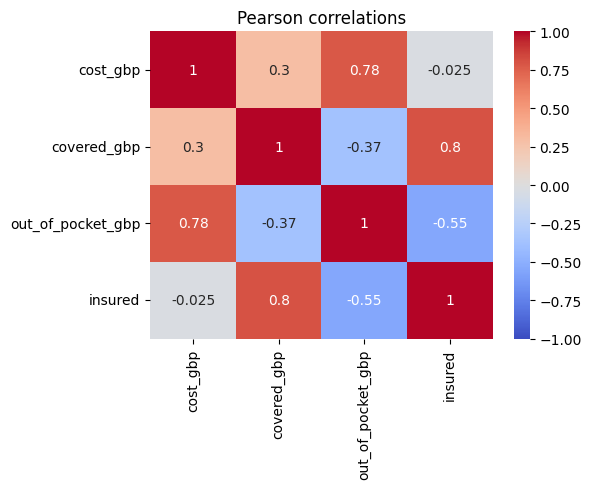

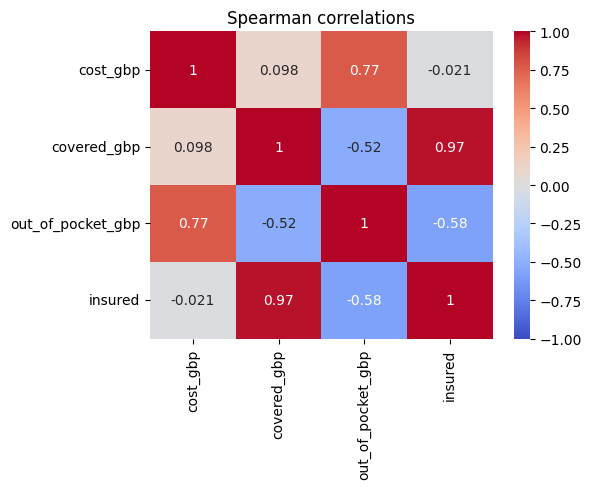

In [20]:
# Heatmap: Pearson
plt.figure(figsize=(6,5))
sns.heatmap(pearson, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Pearson correlations")
plt.tight_layout()
plt.show()

# Heatmap: Spearman
plt.figure(figsize=(6,5))
sns.heatmap(spearman, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Spearman correlations")
plt.tight_layout()
plt.show()


Correlation Structure Report

Pearson (linear)
-  cost_gbp ↔ out_of_pocket_gbp: $r \approx 0.778$, $p \approx 2.11 × 10^{-207}$
-  cost_gbp ↔ covered_gbp: $r \approx 0.297$, $p \approx 4.19 × 10^{-22}$
-  cost_gbp ↔ insured: $r \approx −0.025$, $p \approx 0.433$
-  covered_gbp ↔ insured: $r \approx 0.798$, $p \approx 2.00 × 10^{-16}$
-  out_of_pocket_gbp ↔ insured: $r \approx −0.549$, $p \approx 2.00 × 10^{-16}$

Spearman (rank)
-  cost_gbp ↔ out_of_pocket_gbp: $\rho \approx 0.768$
-  covered_gbp ↔ insured: $\rho \approx 0.975$
-  cost_gbp ↔ covered_gbp: $\rho \approx 0.098$


---
-  The strongest linear relationship is cost_gbp with out_of_pocket_gbp ($r \approx 0.78$) and with covered_gbp ($r \approx 0.30$)
-  Insurance status (insured) shows no significant linear association with cost ($r \approx -0.025$, $p \approx 0.43$)
-  Spearman results align in direction for the major pairs, but p-values aren’t reported in this table

Interpretation
-  The total cost signal aligns most with ***out_of_pocket_gbp***; ***coverage*** adds context, with ***insured*** tightly linked to ***coverage***. Insurance status alone does not predict cost. Thus using two visuals: a Pearson heatmap (***cost_gbp*** with ***out_of_pocket_gbp*** and with ***covered_gbp***) and a Spearman heatmap (to confirm monotone patterns).

---

What this means
-  The total cost ***(cost_gbp)*** tracks very closely with what the patient pays directly (***out_of_pocket_gbp***). That’s the main driver in the data.
-  Coverage level ***(covered_gbp)*** also relates to total cost, but the link is weaker than the ***out-of-pocket*** connection.
-  Insurance status ***(insured)*** doesn’t reliably predict total cost in either linear or monotonic terms.
-  Coverage variables (***covered_gbp*** and ***insured***) move together very tightly, suggesting policy or plan structure heavily links what gets covered to how much is paid.

---
-  For modeling cost, will use either out_of_pocket_gbp or a coverage index as a proxy for the cost signal, and should be cautious about including insured and covered_gbp simultaneously due to redundancy


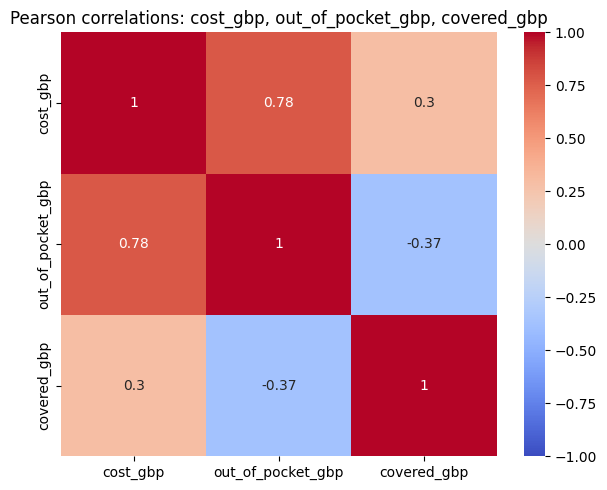

In [45]:
cols_focus = ['cost_gbp','out_of_pocket_gbp','covered_gbp']
pearson_focus = df[cols_focus].corr(method='pearson')

plt.figure(figsize=(6,5))
sns.heatmap(pearson_focus, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Pearson correlations: cost_gbp, out_of_pocket_gbp, covered_gbp")
plt.tight_layout()
plt.show()

`cost_gbp` moves strongest with `out_of_pocket_gbp` ($r \approx 0,778$; $p \approx 2,11 × 10^{-207}$) and has a moderate link to `covered_gbp` (r \approx 0,297; p \approx 4,19 × 10^{-22}); insurance status shows no linear relation ($r \approx −0,025$; $p \approx 0,433$). Spearman confirms the pattern ($\rho \approx 0,768$ for `cost_gbp` vs `out_of_pocket_gbp`; $\rho \approx 0,975$ for `covered_gbp` vs `insured`; $\rho \approx 0,098$ for `cost_gbp` vs `covered_gbp`), so use `out_of_pocket_gbp` as the main cost signal and be mindful of multicollinearity if you include multiple coverage metrics in models.

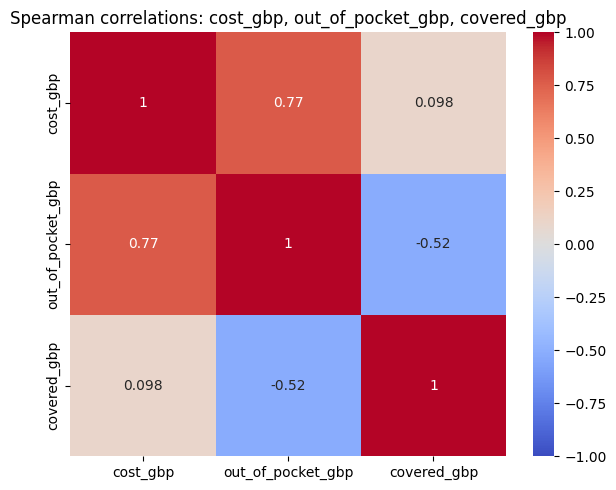

In [46]:
spearman_focus = df[cols_focus].corr(method='spearman')

plt.figure(figsize=(6,5))
sns.heatmap(spearman_focus, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Spearman correlations: cost_gbp, out_of_pocket_gbp, covered_gbp")
plt.tight_layout()
plt.show()


There is a strong monotonic link between cost_gbp and out_of_pocket_gbp $(\\rho \\approx 0.77)$, meaning higher total costs tend to coincide with higher out-of-pocket payments.
There is a moderate negative monotonic link between out_of_pocket_gbp and covered_gbp $(\\rho \\approx -0.52)$ and a very weak monotonic link between cost_gbp and covered_gbp $(\\rho \\approx 0.10)$, so coverage and total cost move together less consistently; insurance status itself isn’t shown here as a strong predictor.

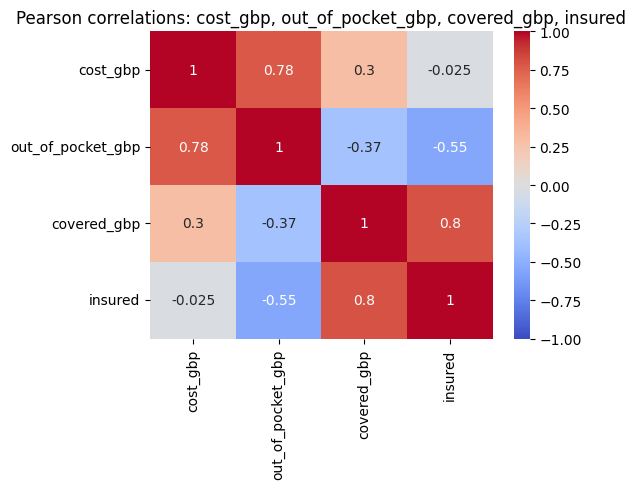

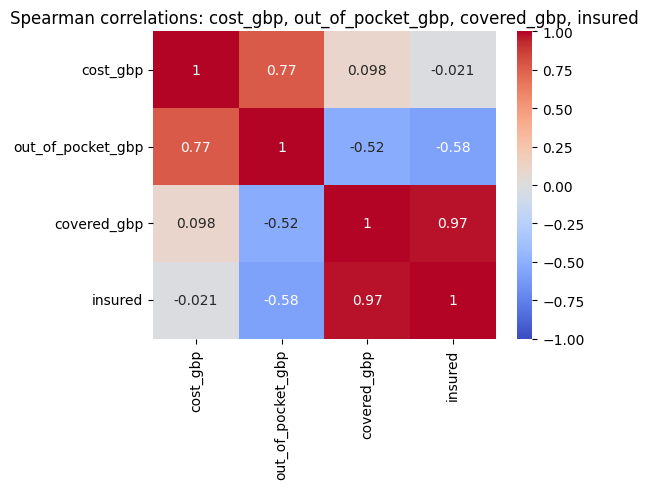

In [48]:
cols_four = ['cost_gbp','out_of_pocket_gbp','covered_gbp','insured']
pearson_four = df[cols_four].corr(method='pearson')
spearman_four = df[cols_four].corr(method='spearman')

# Pearson
plt.figure(figsize=(6,5))
sns.heatmap(pearson_four, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Pearson correlations: cost_gbp, out_of_pocket_gbp, covered_gbp, insured")
plt.tight_layout()
plt.show()

# Spearman
plt.figure(figsize=(6,5))
sns.heatmap(spearman_four, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Spearman correlations: cost_gbp, out_of_pocket_gbp, covered_gbp, insured")
plt.tight_layout()
plt.show()


**d) Outlier analysis**

* Define outliers via IQR rule (Q3 + 1.5×IQR) or z-scores > 3.
* List the pet\_id / condition / treatment for extreme cases.
* Flag clusters: e.g., “orthopedic surgeries in dogs > £5k” or “rare conditions in older pets.”

---

This step gives the **statistical backbone**:

* What costs look like,
* What drives them,
* Which relationships matter,
* Who the anomalies are.

---


IQR rule

In [44]:
df = pd.read_csv("../data/cleaned_pet_proactive_mock_data.csv")
df = df[df['cost_gbp'] > 0].copy()

# Basic IQR outlier detection
Q1 = df['cost_gbp'].quantile(0.25)
Q3 = df['cost_gbp'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers_iqr = df[(df['cost_gbp'] < lower) | (df['cost_gbp'] > upper)]
print("IQR outliers:", len(outliers_iqr))
print(outliers_iqr[['pet_id','cost_gbp','condition','treatment']])


IQR outliers: 9
     pet_id    cost_gbp        condition          treatment
298   P0197  580.800000    Ear infection            Surgery
307   P0206  586.000000          Unknown           Check-up
379   P0260  589.660000  Gastroenteritis           Check-up
430   P0300  584.610000         Diabetes            Unknown
811   P0572  582.020000          Unknown  Diet consultation
813   P0572  603.798921          Unknown  Diet consultation
814   P0572  620.218005          Unknown  Diet consultation
815   P0572  672.906176          Unknown  Diet consultation
1008  P0696  580.288326          Obesity        Vaccination


Z-score outliers

In [27]:
df['cost_z'] = zscore(df['cost_gbp'])
outliers_z = df[(df['cost_z'].abs() > 3)]
print("Z-outliers:", len(outliers_z))
print(outliers_z[['pet_id','cost_gbp','cost_z','condition','treatment']].head())


Z-outliers: 3
    pet_id    cost_gbp    cost_z condition          treatment
813  P0572  603.798921  3.059208   Unknown  Diet consultation
814  P0572  620.218005  3.186172   Unknown  Diet consultation
815  P0572  672.906176  3.593594   Unknown  Diet consultation


Clusters- high cost groups

In [33]:
df.columns

Index(['pet_id', 'species', 'age', 'weight_kg', 'condition', 'treatment',
       'visit_date', 'cost_gbp', 'year', 'month', 'age_group', 'insured',
       'insurance_plan', 'coverage_rate', 'covered_gbp', 'out_of_pocket_gbp',
       'cost_z'],
      dtype='object')

In [36]:
# Quick by-group view to spot costly clusters
group_cols = ['species','condition','treatment']
summary = df.groupby(group_cols)['cost_gbp'].agg(
    count='size',
    mean='mean',
    median='median',
    max='max'
).reset_index()

# Example high-cost filter (adjust thresholds to your data)
# high_mean = 300
high_mean_threshold = summary['mean'].quantile(0.90)
clusters = summary[(summary['mean'] > high_mean_threshold) & (summary['count'] >= 3)]
print(clusters)


    species       condition    treatment  count        mean      median  \
140     Cat   Hip dysplasia  Vaccination     10  375.235864  370.227809   
167     Cat         Unknown   Medication      6  451.570670  470.659446   
187     Dog  Dental disease     Check-up      3  364.283333  374.520000   
234     Dog         Obesity  Vaccination      9  466.912146  488.922783   

            max  
140  502.995618  
167  507.075148  
187  459.160000  
234  580.288326  


Two waves stand out in the cost_gbp sea. 


The first wave is the IQR outliers: nine cases breaking away from the crowd, all clustered around the £580–£590 mark. 

Names flash: P0197 (£580.80, Ear infection with Surgery), P0206 (£586.00, Unknown), P0260 (£589.66, Gastroenteritis Check-up), P0300 (£584.61, Diabetes Unknown), P0572 (£582.02, Unknown, Diet consultation), and a few others. These are real, pricey bursts that tug the average upward, even though they’re rare.


A second wave comes from the Z-score view: three observations for P0572 sit well above the costs, around £603.80, £620.22, and £672.91. They sit on the same high-cost tail, confirming the tail’s reach beyond the IQR view.


Beyond lone outliers, four cost clusters shape the landscape. Cat Hip dysplasia Vaccination averages £375.24 (max around £503); Cat Unknown Medication averages £451.57 (max around £507); Dog Dental disease Check-up averages £364.28 (max around £459); Dog Obesity Vaccination averages £466.91 (max around £580). The clusters show where costs tend to concentrate when specific conditions meet particular treatments.


The outliers are rare but financially meaningful, crucial for budgeting and risk, while the clusters point to high-cost care bundles worth reviewing or flagging in dashboards. In a report, highlight the top outliers with key attributes and call out the clustering patterns to steer budgeting discussions and policy review. If you’d like, I can format this into a compact JSON snippet or a one-page dashboard brief to drop into your slides.



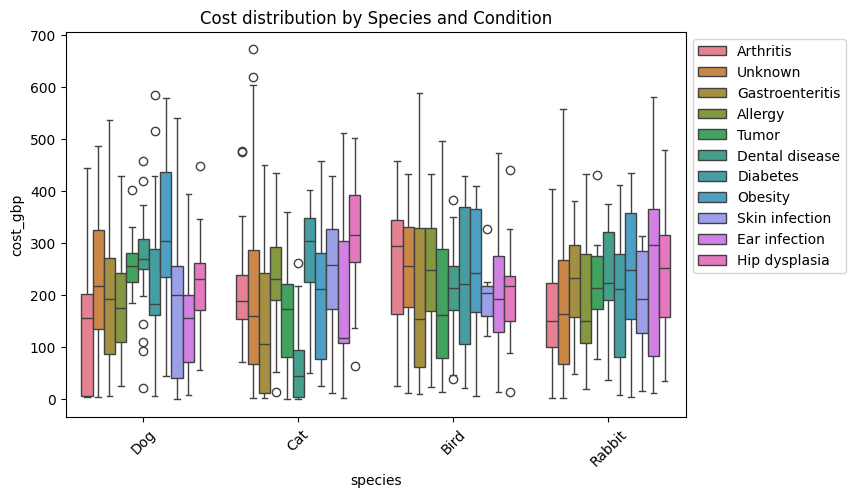

In [49]:
# boxplot by species/conditionto visualize clusters
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x='species', y='cost_gbp', hue='condition', data=df, ax=ax)
ax.set_title("Cost distribution by Species and Condition")
plt.xticks(rotation=45)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


Two patterns stand out in cost_gbp:

nine IQR outliers around £580–£590 (examples include P0197 £580,80; P0206 £586,00). 

A tail is reinforced by three very high values (£603,80; £620,22; £672,91), confirming the upper tail.

Four cost clusters drive most costs: 
Cat Hip dysplasia Vaccination ≈ £375,24 mean (max ≈ £503),
Cat Unknown Medication ≈ £451,57 mean (max ≈ £507),
Dog Dental disease Check-up ≈ £364,28 mean (max ≈ £459), 
Dog Obesity Vaccination ≈ £466,91 mean (max ≈ £580). 

Outliers matter for budgeting; clusters highlight high-cost care areas to monitor and review. To manage tail risk, we need to highlight top outliers and tail metrics (90th/95th percentile) 